In [73]:
import random
import shutil
import time
import warnings
import sys
import torch
import os
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.nn.init as init
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from __future__ import print_function
import argparse
import time
import math
import torch.backends.cudnn as cudnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:

import os

import PIL.Image
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

from torchvision import transforms


class Skin7(Dataset):
    """SKin Lesion"""
    def __init__(self, root="./datas", train=True,transform=None):
        self.root = os.path.join(root)
        #labels
        
        self.train = train
        self.data = pd.read_csv(root+"/annotation/train.csv") if train else pd.read_csv(root+"/annotation/test.csv")
        self.data["image_train"] = root + '/images/' + self.data["image_train"]
        self.transform = transform

    def __getitem__(self, index):
        img_path, label = self.data.iloc[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

    def __len__(self):
        return len(self.data)


In [76]:
class Skin7_1(Dataset):
    def __init__(self, root="./datas", train=True,transform=None):
        self.root = os.path.join(root)
        #labels
        
        self.train = train
        self.data = pd.read_csv(root+"/annotation/train.csv") if train else pd.read_csv(root+"/annotation/test.csv")
        self.data["image_train"] = root + '/images/' + self.data["image_train"]
        self.transform = transform

    def __getitem__(self, index):

        img_path, label = self.data.iloc[index]
        img = Image.open(img_path)
        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.data)


In [77]:
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

trainset = Skin7_1(train=True, transform=train_transform)
testset = Skin7_1(train=False, transform=test_transform)

In [78]:
df = pd.read_csv("./datas/annotation/train.csv")
df_test = pd.read_csv("./datas/annotation/test.csv")
len(df_test)

99

In [79]:
print(trainset[1].size())

torch.Size([3, 450, 600])


In [80]:
#params
batch_size = 16

In [81]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size,
                                          shuffle=True, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size,
                                          shuffle=False, pin_memory=True)

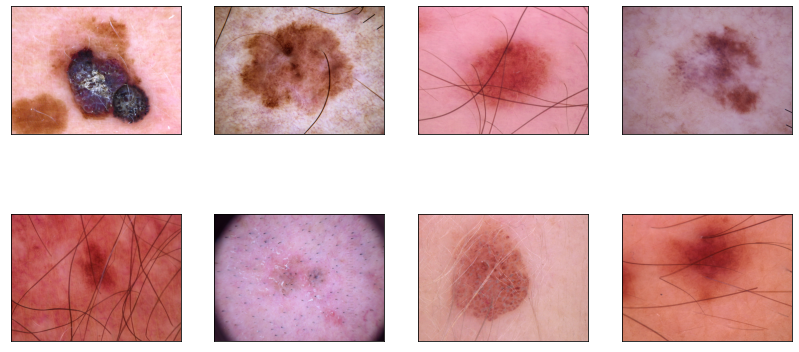

In [82]:
import matplotlib.pyplot as plt
for batch_idx, inputs in enumerate(trainloader):
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    break

In [83]:
psum  = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(trainloader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])


100%|██████████| 20/20 [00:02<00:00,  7.09it/s]


In [84]:
psum_test  = torch.tensor([0.0, 0.0, 0.0])
psum_sq_test = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs in tqdm(testloader):
    psum_test   += inputs.sum(axis        = [0, 2, 3])
    psum_sq_test += (inputs ** 2).sum(axis = [0, 2, 3])

100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


In [85]:
count = len(df) * 450 * 600

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.7863, 0.5326, 0.5560])
std:  tensor([0.1335, 0.1502, 0.1694])


In [86]:
count_test = len(df_test) * 450 * 600

# mean and std
total_mean_test = psum_test / count_test
total_var_test  = (psum_sq_test / count_test) - (total_mean_test ** 2)
total_std_test  = torch.sqrt(total_var_test)

# output
print('mean: '  + str(total_mean_test))
print('std:  '  + str(total_std_test))

mean: tensor([0.7721, 0.5408, 0.5638])
std:  tensor([0.1310, 0.1389, 0.1561])


In [87]:
import torch
import torch.nn as nn

from math import log
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):

        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):

        device = torch.device("cuda") if features.is_cuda else torch.device("cpu")
        

        dot_product_tempered = torch.div(torch.matmul(features, features.T),self.temperature)
        exp_dot_tempered = (
            torch.exp(dot_product_tempered - torch.max(dot_product_tempered, dim=1, keepdim=True)[0]) + 1e-5
        )
        
        mask_similar_class = (labels.unsqueeze(1).repeat(1, labels.shape[0]) == labels).to(device)
        mask_anchor_out = (1 - torch.eye(exp_dot_tempered.shape[0])).to(device)
        mask_combined = mask_similar_class * mask_anchor_out
        cardinality_per_samples = torch.sum(mask_combined, dim=1)
        for i in range(len(cardinality_per_samples)):
            if cardinality_per_samples[i] == 0:
                cardinality_per_samples[i] = 0.00001

        log_prob = -torch.log(exp_dot_tempered / (torch.sum(exp_dot_tempered * mask_anchor_out, dim=1, keepdim=True)))
        supervised_contrastive_loss_per_sample = torch.sum(log_prob * mask_combined, dim=1) / cardinality_per_samples
        loss = torch.mean(supervised_contrastive_loss_per_sample)

        return loss

In [88]:
from __future__ import print_function

import math
import numpy as np
import torch
import torch.optim as optim

class ContrastiveLearningViewGenerator(object):


    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]
   
def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


In [89]:
normalize = transforms.Normalize(mean=total_mean, std=total_std)
train_transform = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(400),
                                      transforms.ToTensor(),
                                      normalize,
                                     ])
normalize_test = transforms.Normalize(mean=total_mean_test, std=total_std_test)
test_transform = transforms.Compose([transforms.RandomRotation(35),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.CenterCrop(400),
                                      transforms.ToTensor(),
                                      normalize,])

trainset = Skin7(train=True, transform=ContrastiveLearningViewGenerator(train_transform))
testset = Skin7(train=False, transform=test_transform)

In [90]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size,
                                          shuffle=True,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size,
                                          shuffle=False,pin_memory=True)

In [91]:

import torch
import torch.nn as nn
import torchvision.models.resnet
from torchvision.models.resnet import BasicBlock, Bottleneck

class ResNet(torchvision.models.resnet.ResNet):
    def __init__(self, block, layers, num_classes=7, group_norm=False):
        if group_norm:
            norm_layer = lambda x: nn.GroupNorm(32, x)
        else:
            norm_layer = None
        super(ResNet, self).__init__(block, layers, num_classes, norm_layer=norm_layer)
        if not group_norm:
            self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True) # change
            for i in range(2, 5):
                getattr(self, 'layer%d'%i)[0].conv1.stride = (2,2)
                getattr(self, 'layer%d'%i)[0].conv2.stride = (1,1)
def resnet50(pretrained=False):

    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


In [92]:

from torchvision.models import resnet

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"
   
  # Initialize the model using the legacy API
net = resnet.resnet50(pretrained=True)
#net = models.resnet50(pretrained=True)
net.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(net.fc.in_features, 7)
)
net = net.to(device)
#print(model)


In [93]:
def set_model():
    model = net
    criterion = SupervisedContrastiveLoss()

    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model.encoder = torch.nn.DataParallel(model.encoder)
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    return model, criterion

In [94]:
Max_epoch = 80

In [95]:
train_Acc_list = []
train_loss_list = []
def train(trainloader, model, criterion, learning_rate,epoch):
    """one epoch training"""
    if epoch % 10 == 0:
        learning_rate = learning_rate * 0.5
        optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=1e-4)
    else:
        optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate,
                      momentum=0.9,
                      weight_decay=1e-4)
    model.train()
    losses = []
    scores = []
    running_correct = 0
    train_loss = 0
    correct = 0
    total = 0
    gt_list = []
    pred_list = []
    
    for idx, (images, labels) in enumerate(trainloader):
        bsz = labels.shape[0]
        #print("0",images[0],"1", images[1])
        images = torch.cat([images[0], images[1]], dim=0)
        labels = labels.repeat(2)
        if torch.cuda.is_available():
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
        optimizer.zero_grad()
        
        features = model(images)

        
        contrastive_loss= criterion(features, labels)

        cross_loss =torch.nn.functional.cross_entropy(features, labels)
        loss = contrastive_loss + cross_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pred = torch.argmax(features, dim=1)
        
        _, predicted = features.max(1)
 
        total_batch = labels.size(0)
        correct_batch = predicted.eq(labels).sum().item()
        total += total_batch
        correct += correct_batch

        

    train_acc=100.0 * correct / total
    avg_loss = train_loss/len(trainloader)
    print('=>train loss: {:.4f}'.format(avg_loss))
    print('=>train accuracy:{:.4f}'.format(train_acc))
    #train_loss_list.append(losses)
    return avg_loss,train_acc
               

In [96]:
def test( model, testloader, criterion):

    model.eval()
    test_loss = 0
    running_correct=0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            contrastive_loss= criterion(outputs, labels)
            cross_loss =torch.nn.functional.cross_entropy(outputs, labels)
            loss = contrastive_loss + cross_loss
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_batch = labels.size(0)
            correct_batch = predicted.eq(labels).sum().item()
            total += total_batch
            correct += correct_batch

    loss_test = test_loss/len(testloader)
    test_acc=100.0 * correct / total

    print('=>test accuracy: {:.4f}'.format(test_acc))
    print('=>test loss: {:.4f}'.format(loss_test))
    return loss_test,test_acc


In [97]:
model, criterion = set_model()
learning_rate = 0.001
train_Acc_list = []
train_loss_list = []
test_Acc_list = []
test_loss_list = []
for epoch in range(1, Max_epoch + 1):
    print('epoch {}:'.format(epoch))
    train_loss ,train_acc= train(trainloader, model, criterion, learning_rate,epoch)
    test_loss ,test_acc= test( model, testloader, criterion)
    train_Acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_Acc_list.append(test_acc)
    test_loss_list.append(test_loss)
print("Done!")    

epoch 1:
=>train loss: 5.2847
=>train accuracy:35.7377
=>test accuracy: 62.6263
=>test loss: 3.9381
epoch 2:
=>train loss: 5.0013
=>train accuracy:64.5902
=>test accuracy: 69.6970
=>test loss: 3.9081
epoch 3:
=>train loss: 4.9461
=>train accuracy:68.5246
=>test accuracy: 69.6970
=>test loss: 3.8955
epoch 4:
=>train loss: 4.8863
=>train accuracy:68.5246
=>test accuracy: 75.7576
=>test loss: 3.8123
epoch 5:
=>train loss: 4.7856
=>train accuracy:71.3115
=>test accuracy: 72.7273
=>test loss: 3.7928
epoch 6:
=>train loss: 4.7908
=>train accuracy:72.6230
=>test accuracy: 74.7475
=>test loss: 3.7521
epoch 7:
=>train loss: 4.7228
=>train accuracy:73.1148
=>test accuracy: 73.7374
=>test loss: 3.7347
epoch 8:
=>train loss: 4.6648
=>train accuracy:71.9672
=>test accuracy: 71.7172
=>test loss: 3.7892
epoch 9:
=>train loss: 4.6371
=>train accuracy:74.9180
=>test accuracy: 70.7071
=>test loss: 3.7281
epoch 10:
=>train loss: 4.6101
=>train accuracy:73.9344
=>test accuracy: 71.7172
=>test loss: 3.7656

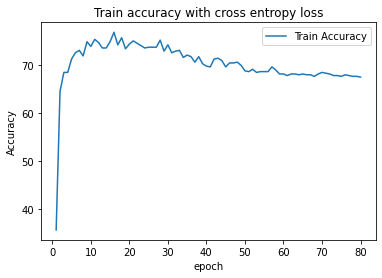

In [98]:
#plot train accuracy in each epoch
import matplotlib.pyplot as plt
%matplotlib inline
dim1 = []
dim1.extend(range(1, 81))
plt.plot(dim1,train_Acc_list,label='Train Accuracy')
plt.title('Train accuracy with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

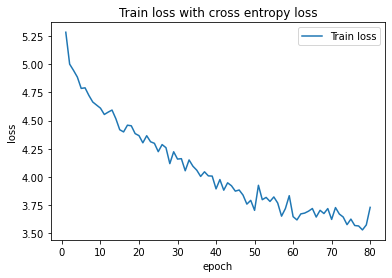

In [99]:
#plot train loss in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,train_loss_list,label='Train loss')
plt.title('Train loss with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

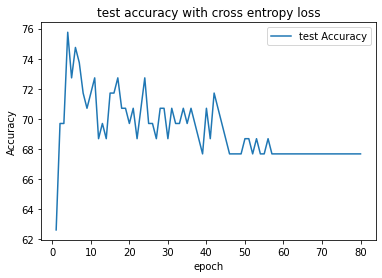

In [100]:
#plot test accuracy in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_Acc_list,label='test Accuracy')
plt.title('test accuracy with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

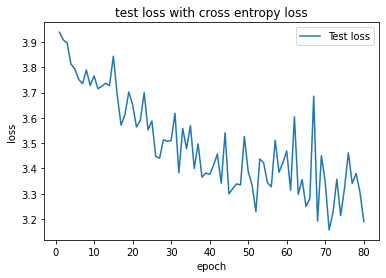

In [101]:
#plot test loss in each epochimport matplotlib.pyplot as plt
plt.plot(dim1,test_loss_list,label='Test loss')
plt.title('test loss with cross entropy loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()